In [ ]:
# This work relies on the the fantatic fastai library (https://github.com/fastai/fastai) 
# and iceVision library (https://github.com/airctic/icevision)
# Before runing this notebook, please run 'coda env create -f environment_icevision.yml' in the terminal or Anaconda Prompt
# Then, Activate the new environment

In [ ]:
# We use 100 samples for demonstration

In [1]:
from icevision.all import *

In [2]:
from PIL import Image
from numpy import asarray

In [3]:
import pandas as pd
from pandas import DataFrame,Series

from datetime import datetime

In [4]:
torch.cuda.set_device('cuda:4')

In [5]:
# model_type = models.mmdet.retinanet
# backbone = model_type.backbones.resnet50_fpn_1x(pretrained=True)

In [6]:
# model_type = models.torchvision.retinanet
# backbone = model_type.backbones.resnet50_fpn(pretrained=True)

In [7]:
# model_type = models.ross.efficientdet
# backbone = model_type.backbones.tf_lite0(pretrained=True)

In [5]:
model_type = models.ultralytics.yolov5
backbone = model_type.backbones.small(pretrained=True)

In [6]:
image_dir = Path('../content_design_image_segmentation/data/export/grayscale/')

In [7]:
annotation_dir = Path('../content_design_image_segmentation/data/export/iceAnnotations/')

In [8]:
# Parser
parser = parsers.VOCBBoxParser(annotations_dir=annotation_dir, images_dir=image_dir)

In [9]:
train_records, valid_records = parser.parse()

  0%|          | 0/100 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:136


In [10]:
train_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(384), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(384), tfms.A.Normalize()])

In [11]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

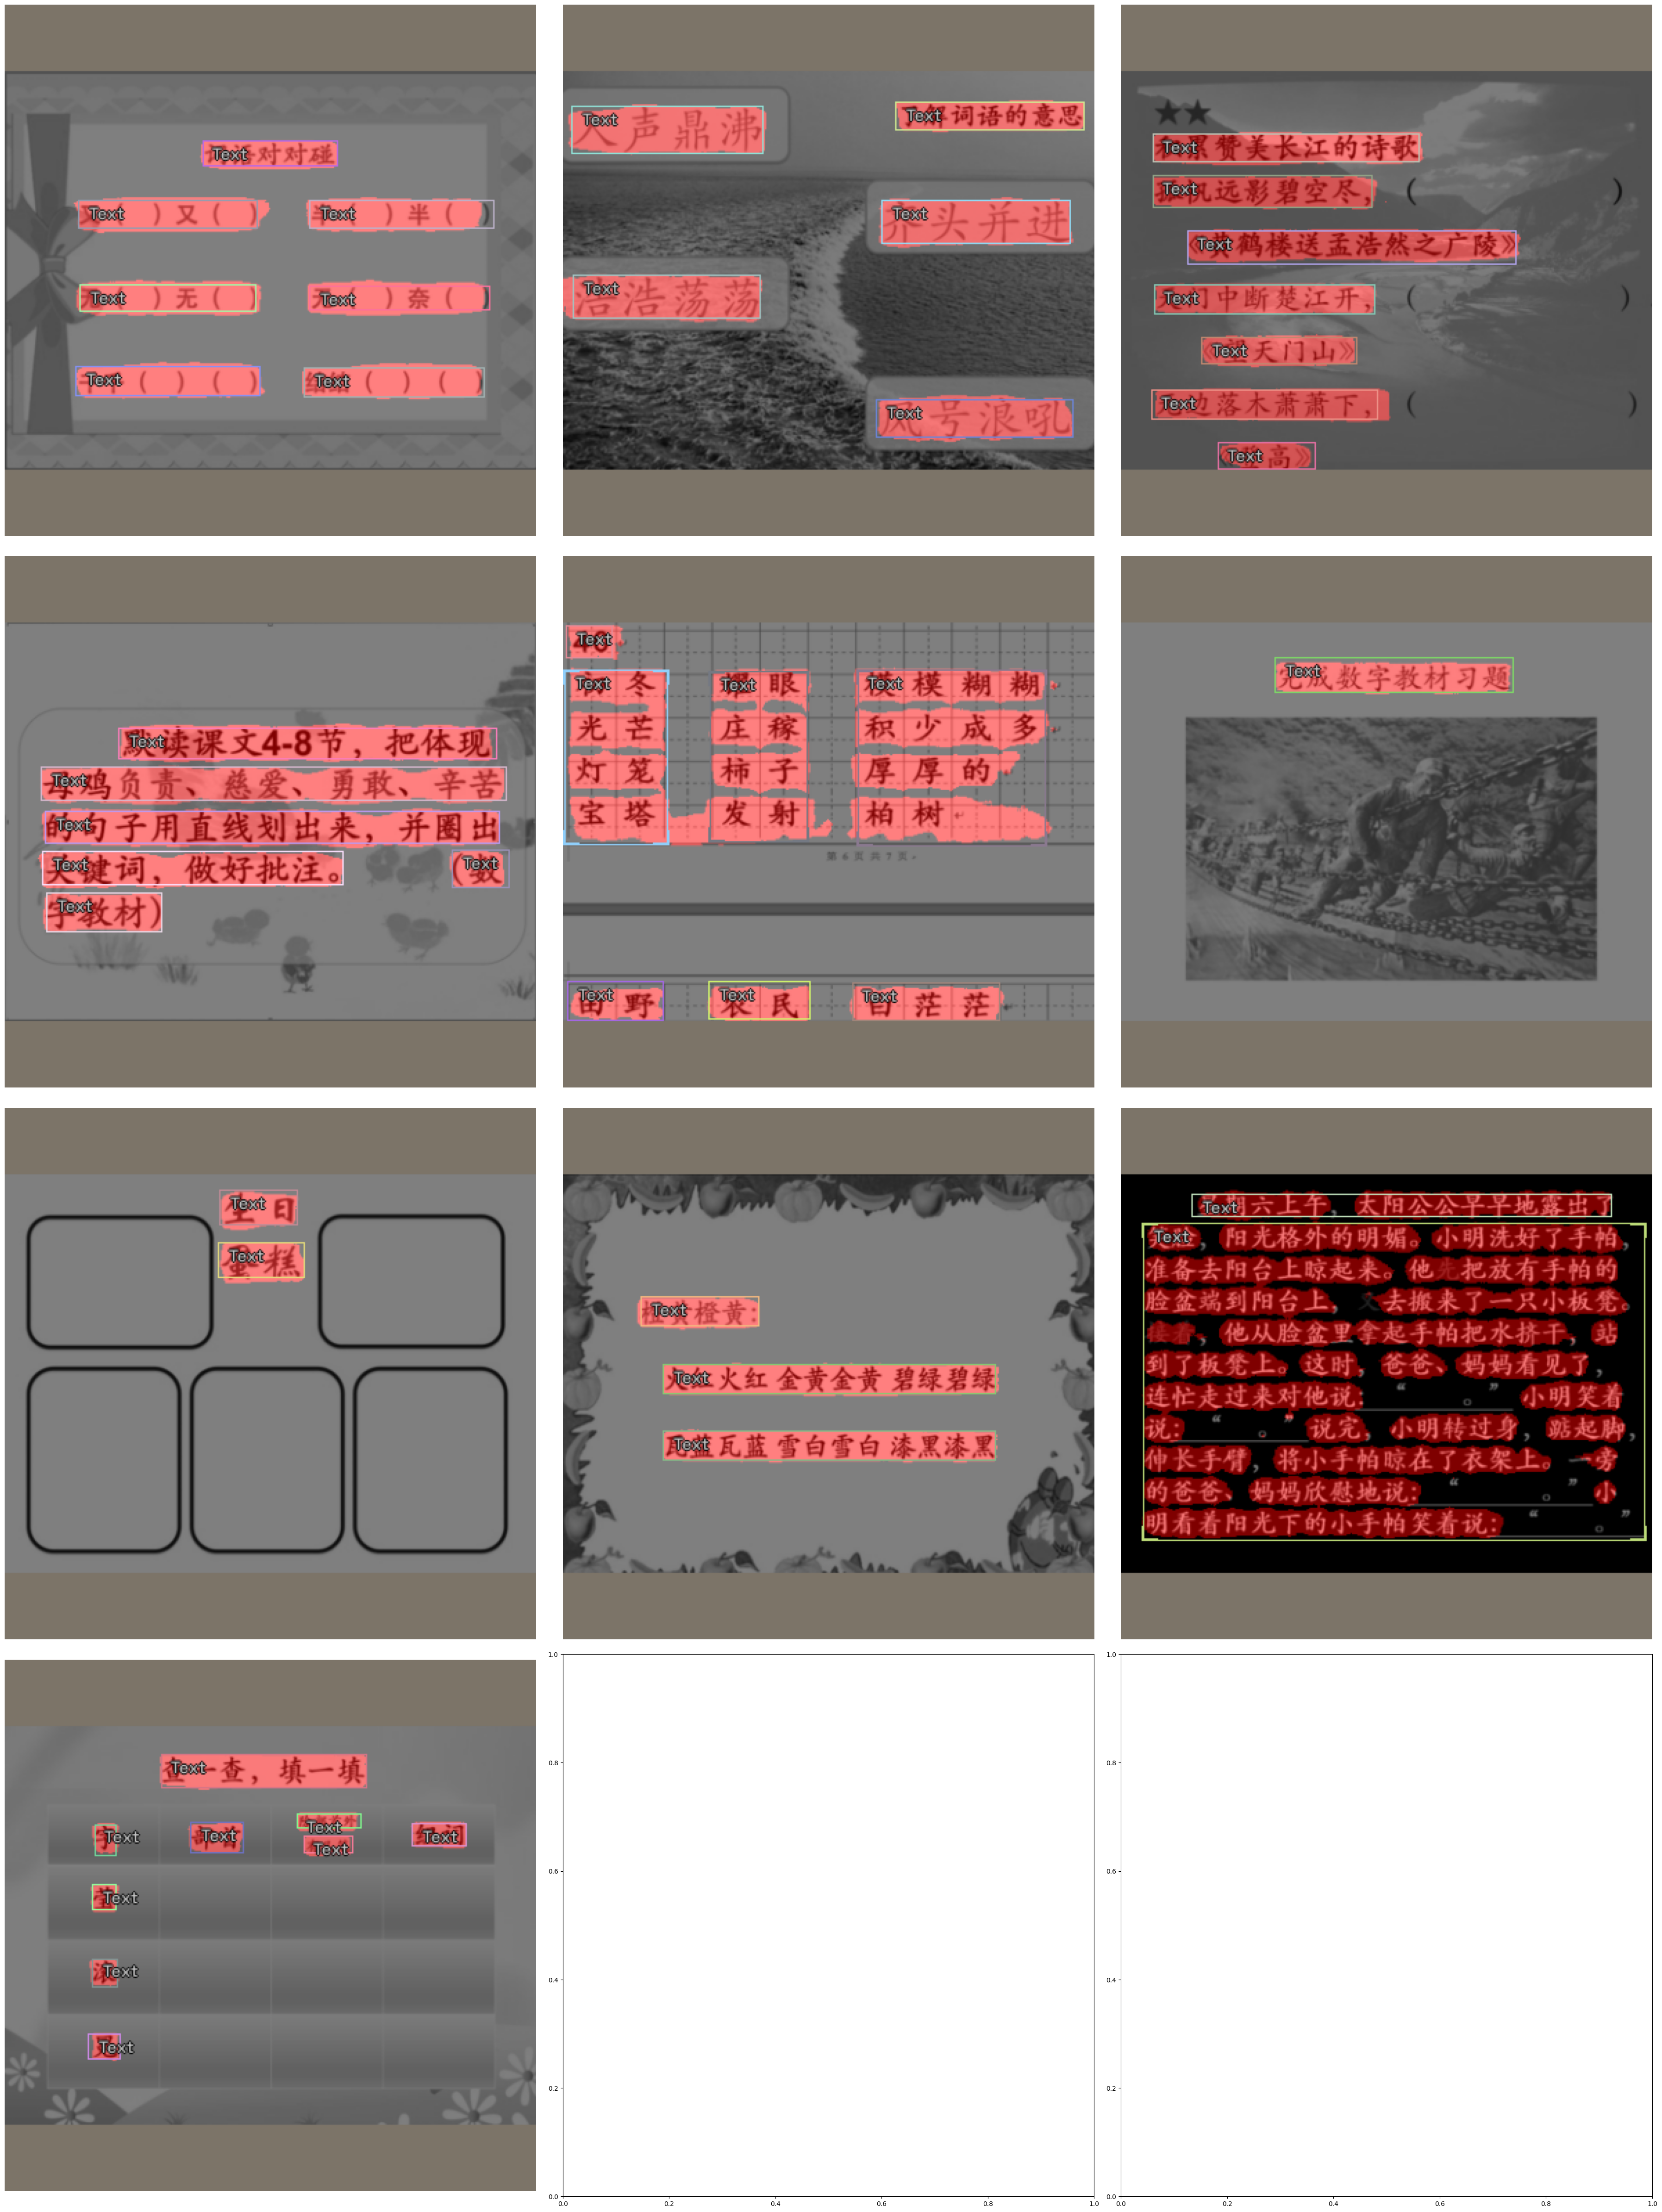

In [12]:
# For demonstration purposes, there is only code of textual component in this demo
samples = [train_ds[_] for _ in range(-10,0)]
show_samples(samples, ncols=3, class_map=parser.class_map)

In [13]:
# DataLoaders
train_dl = model_type.train_dl(train_ds, batch_size=4, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=4, num_workers=4, shuffle=False)

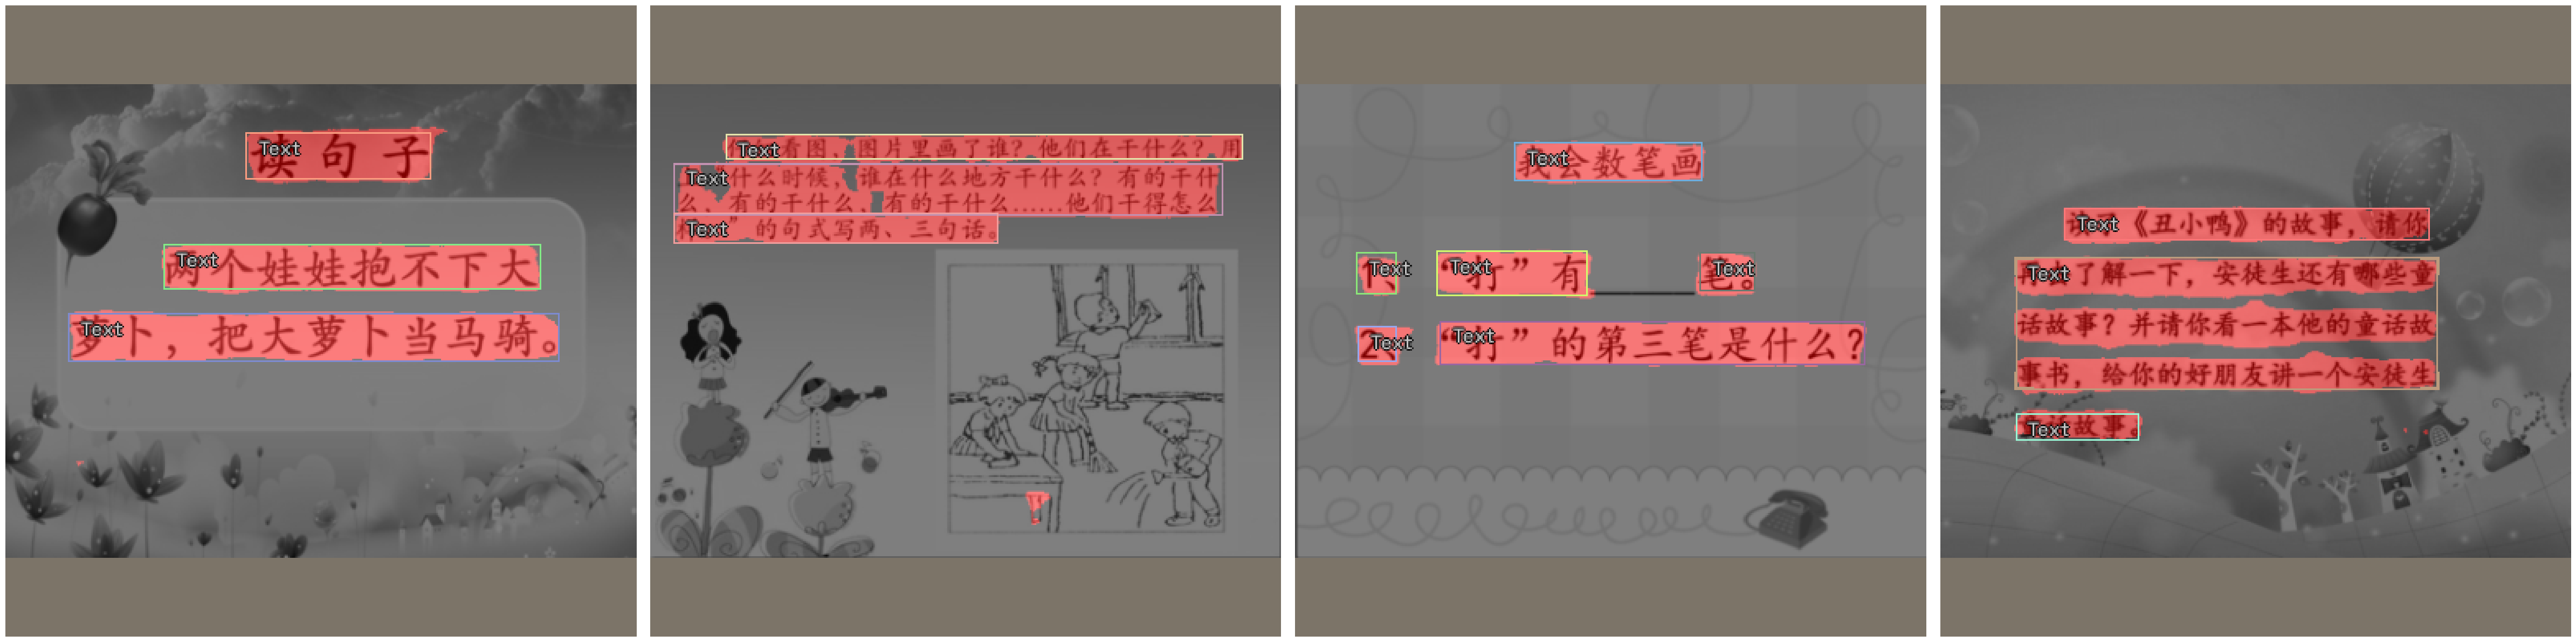

In [14]:
# show batch
model_type.show_batch(first(valid_dl), ncols=4)

In [15]:
parser.class_map

<ClassMap: {'background': 0, 'text': 1}>

In [16]:
# pretrained=True is a default setting, and can be omitted
# model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map)) 

model = model_type.model(backbone=backbone(), num_classes=len(parser.class_map), img_size=384)

In [17]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [18]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=6.309573450380412e-07)

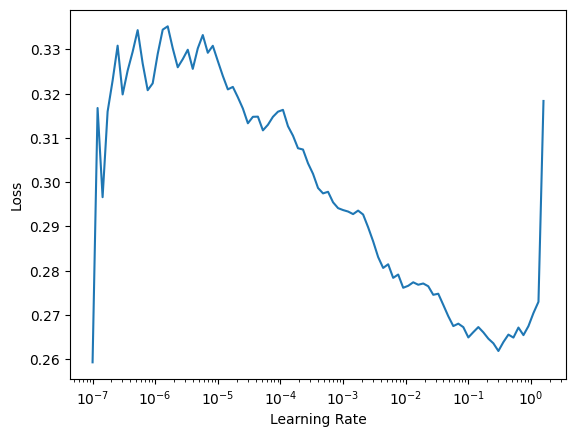

In [19]:
learn.lr_find()

In [20]:
learn.fine_tune(35, 3e-2, freeze_epochs=2)

In [22]:
learn.fine_tune(30, 1e-3, freeze_epochs=0)

In [21]:
learn.fine_tune(5, 1e-4, freeze_epochs=0)

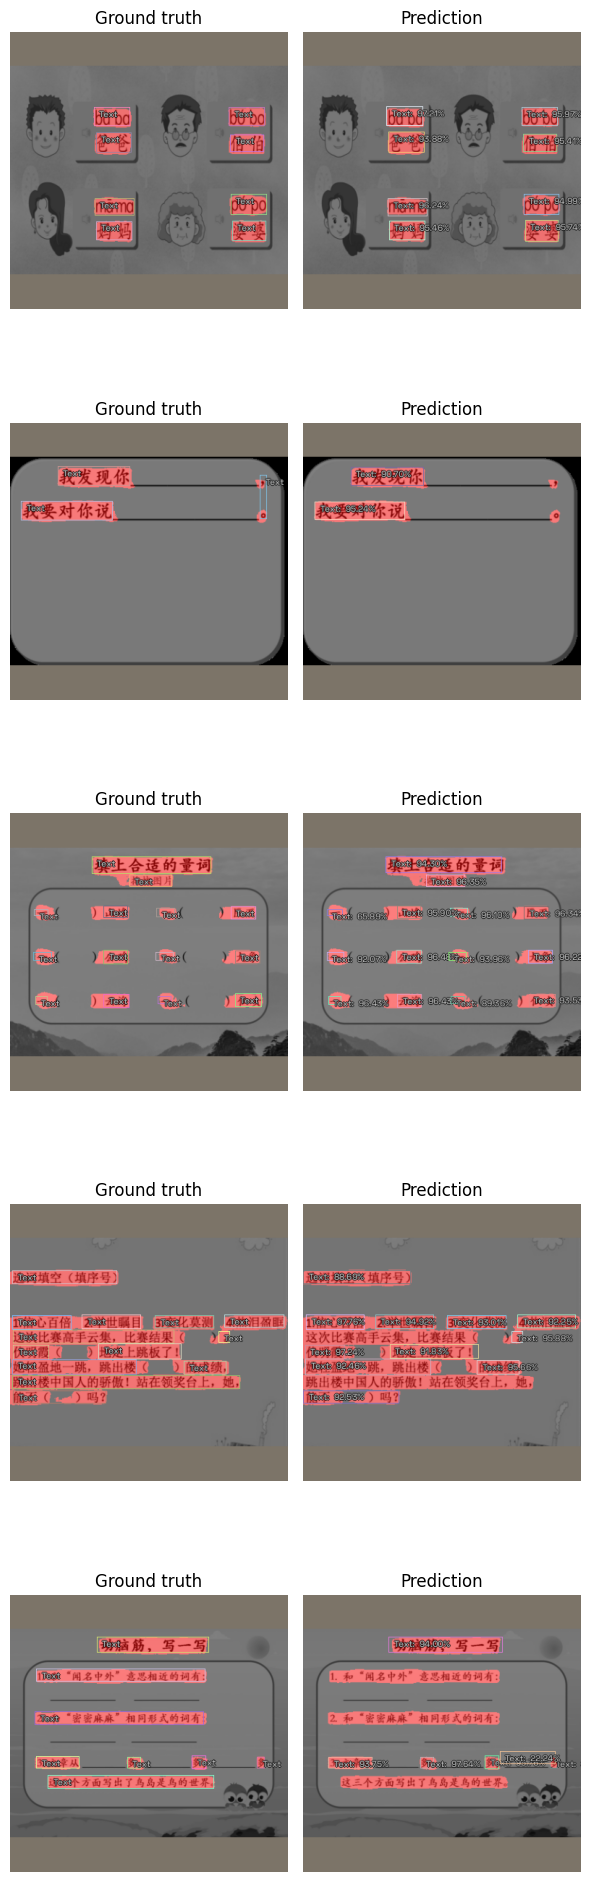

In [23]:
model_type.show_results(model, train_ds, detection_threshold=.1,num_samples=5)

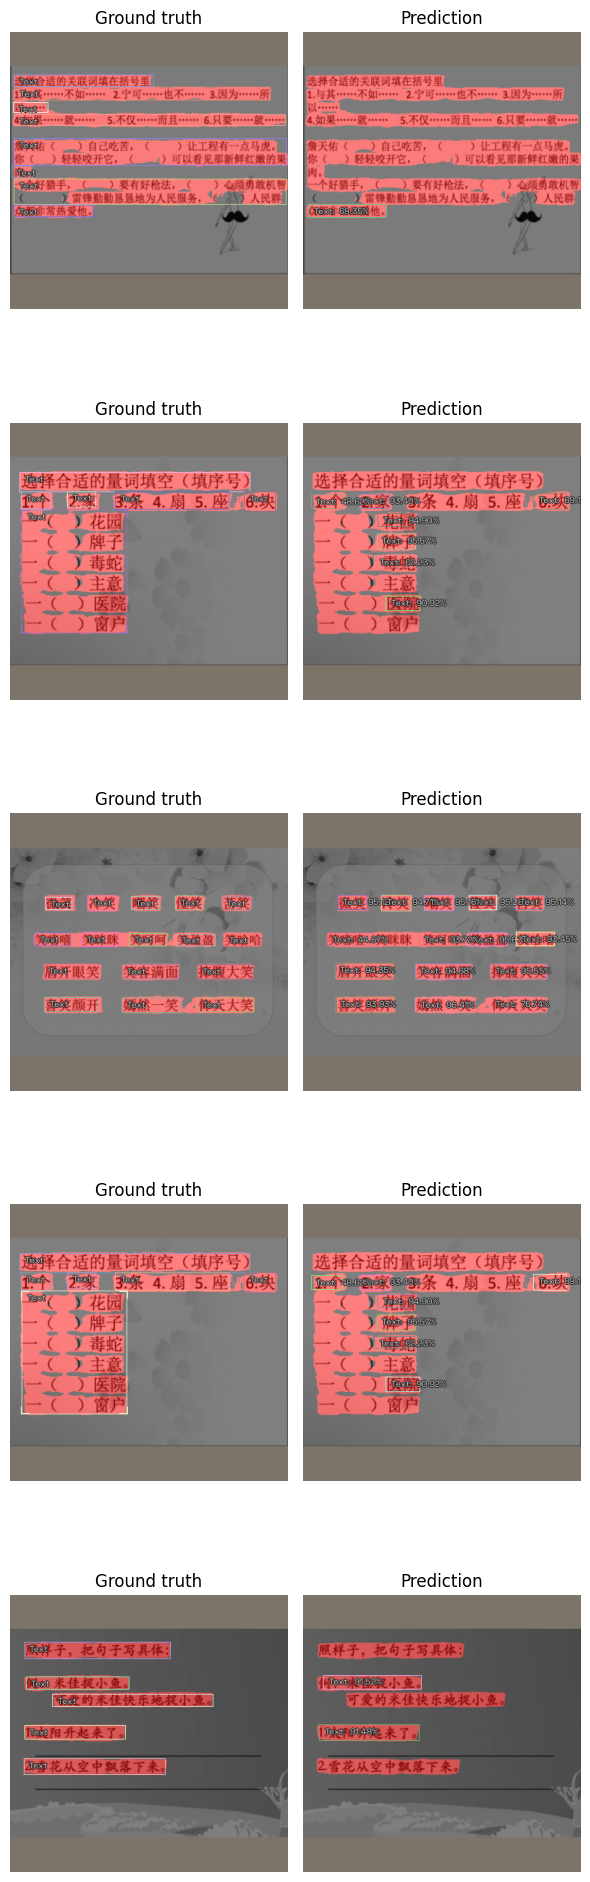

In [25]:
model_type.show_results(model, valid_ds, detection_threshold=.4,num_samples=5)

In [ ]:
###
#**NOTE** Only 100 samples are usded in the this demo. 
# So the trained model is too limited to detect the texts of content
# Better detection requires input of much more annotated artifact data

# inference

In [28]:
torch.save(model.state_dict(),'./models/text_sample.pth')

In [25]:
state_dict_load = torch.load('./models/text_sample.pth')

In [26]:
model.load_state_dict(state_dict_load)

<All keys matched successfully>

In [35]:
infer_dl = model_type.infer_dl(valid_ds, batch_size=4, shuffle=False)
preds = model_type.predict_dl(model, infer_dl, keep_images=True)

  0%|          | 0/3 [00:00<?, ?it/s]

In [55]:
preds[0].pred.aggregate_objects()

{'common': {'img_size': [{'img_width': 384, 'img_height': 384}]},
 'detection': {'bboxes': [{'bbox_x': 50.482407,
    'bbox_y': 186.09856,
    'bbox_width': 30.900238,
    'bbox_height': 15.592316,
    'bbox_sqrt_area': 21.9500859773729,
    'bbox_aspect_ratio': 1.9817606},
   {'bbox_x': 95.220604,
    'bbox_y': 168.81061,
    'bbox_width': 30.932144,
    'bbox_height': 12.321716,
    'bbox_sqrt_area': 19.522733299374746,
    'bbox_aspect_ratio': 2.5103762},
   {'bbox_x': 167.28178,
    'bbox_y': 243.6004,
    'bbox_width': 32.429413,
    'bbox_height': 31.569946,
    'bbox_sqrt_area': 31.99679358630623,
    'bbox_aspect_ratio': 1.0272242},
   {'bbox_x': 229.28159,
    'bbox_y': 220.3898,
    'bbox_width': 30.24646,
    'bbox_height': 18.553223,
    'bbox_sqrt_area': 23.689012464082108,
    'bbox_aspect_ratio': 1.6302537},
   {'bbox_x': 51.94702,
    'bbox_y': 222.88657,
    'bbox_width': 31.645264,
    'bbox_height': 24.343262,
    'bbox_sqrt_area': 27.755160564988294,
    'bbox_aspec

In [58]:
preds[0].pred.as_dict()

{'common': {'record_id': 46,
  'width': 384,
  'height': 384,
  'img': array([[[  0.0055655,  -0.0049019,   0.0081917],
          [  0.0055655,  -0.0049019,   0.0081917],
          [  0.0055655,  -0.0049019,   0.0081917],
          ...,
          [  0.0055655,  -0.0049019,   0.0081917],
          [  0.0055655,  -0.0049019,   0.0081917],
          [  0.0055655,  -0.0049019,   0.0081917]],
  
         [[  0.0055655,  -0.0049019,   0.0081917],
          [  0.0055655,  -0.0049019,   0.0081917],
          [  0.0055655,  -0.0049019,   0.0081917],
          ...,
          [  0.0055655,  -0.0049019,   0.0081917],
          [  0.0055655,  -0.0049019,   0.0081917],
          [  0.0055655,  -0.0049019,   0.0081917]],
  
         [[  0.0055655,  -0.0049019,   0.0081917],
          [  0.0055655,  -0.0049019,   0.0081917],
          [  0.0055655,  -0.0049019,   0.0081917],
          ...,
          [  0.0055655,  -0.0049019,   0.0081917],
          [  0.0055655,  -0.0049019,   0.0081917],
          [